In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from threadpoolctl import threadpool_limits

In [44]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [45]:
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [46]:
customer_transactions = transactions_df.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    avg_spent=("TotalValue", "mean"),
    num_transactions=("TransactionID", "count"),
    distinct_products=("ProductID", "nunique")
).reset_index()

In [47]:
customer_features = customers_df.merge(customer_transactions, on="CustomerID", how="left")
customer_features.fillna(0, inplace=True)

In [48]:
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

In [49]:
feature_cols = [col for col in customer_features.columns if col not in ["CustomerID", "CustomerName", "SignupDate"]]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[feature_cols])

In [50]:
cluster_range = range(2, 11)
db_scores = []

In [51]:
for k in cluster_range:
    with threadpool_limits(limits=1, user_api="blas"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_features)
        db_index = davies_bouldin_score(scaled_features, cluster_labels)
        db_scores.append(db_index)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

KeyboardInterrupt: 

In [52]:
optimal_k = cluster_range[np.argmin(db_scores)]

In [53]:
with threadpool_limits(limits=1, user_api="blas"):
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    customer_features["Cluster"] = kmeans_final.fit_predict(scaled_features)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [54]:
cluster_summary = customer_features.groupby("Cluster").agg(
    avg_total_spent=("total_spent", "mean"),
    avg_num_transactions=("num_transactions", "mean"),
    avg_distinct_products=("distinct_products", "mean"),
    customer_count=("CustomerID", "count")
).reset_index()


In [55]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
customer_features["PCA1"] = pca_features[:, 0]
customer_features["PCA2"] = pca_features[:, 1]


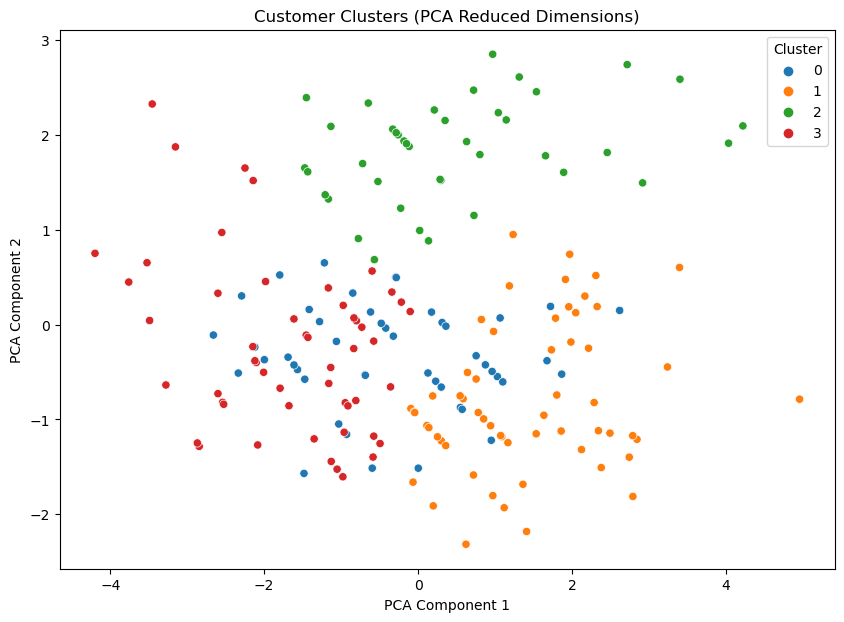

In [56]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    palette="tab10",
    data=customer_features,
    legend="full"
)
plt.title("Customer Clusters (PCA Reduced Dimensions)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [57]:
cluster_summary_path = "C:/Users/DELL/Documents/zeotab challange/Customer_Clusters.csv"
customer_features.to_csv(cluster_summary_path, index=False)